In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Binary classification of chest X-rays

> In this tutorial we will build a classifier that distinguishes between chest X-rays with pneumothorax and chest X-rays without pneumothorax. The image data is loaded directly from the DICOM source files, so no prior DICOM data handling is needed.

## Download and import of X-ray DICOM files

First, we will use the `untar_data` function to download the _siim_small_ folder containing a subset (250 DICOM files, \~30MB) of the [SIIM-ACR Pneumothorax Segmentation](https://doi.org/10.1007/s10278-019-00299-9) \[1\] dataset.
The downloaded _siim_small_ folder will be stored in your _\~/.fastai/data/_ directory. The variable `pneumothorax-source` will store the absolute path to the _siim_small_ folder as soon as the download is complete.

In [ ]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

The _siim_small_ folder has the following directory/file structure:

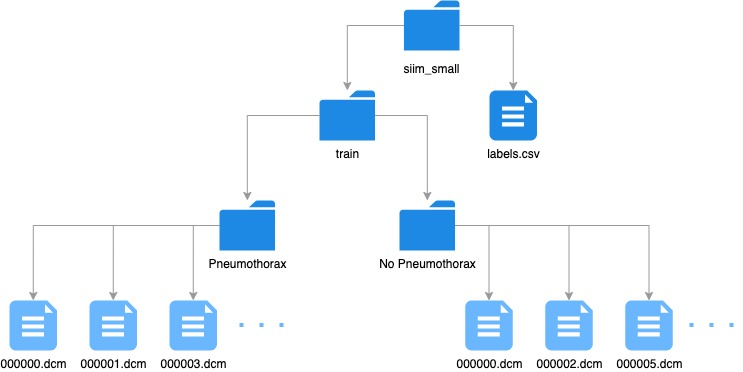

### Loading the data with `Datasets`

To analyze our dataset, we load the paths to the DICOM files with the `get_dicom_files` function. When calling the function, we append _train/_ to the `pneumothorax_source` path to choose the folder where the DICOM files are located. We store the path to each DICOM file in the `items` list.

In [ ]:
items = get_dicom_files(pneumothorax_source/f"train/")

Next, we split the `items` list into a train `trn` and validation `val` list using the `RandomSplitter` function:

In [ ]:
trn,val = RandomSplitter()(items)

To plot an X-ray, we can select an entry in the `items` list and load the DICOM file with `dcmread`. plot it with `show`.

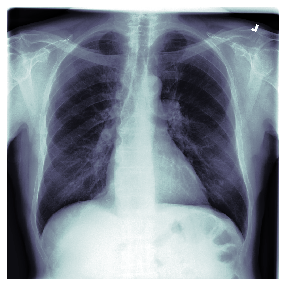

In [ ]:
xray_sample = items[3].dcmread()
xray_sample.show()

TODO: UPDATE TEXT: Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

Next, we need to load the labels for the dataset. In this case, the labels indicate whether the xray shows a pneumothorax or not.

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


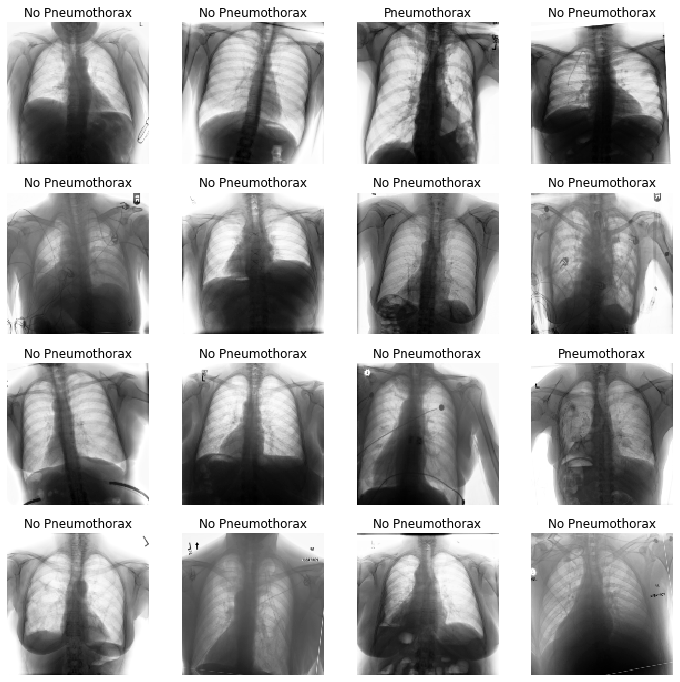

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=128, flip_vert=False, max_lighting=0.2, max_zoom=1.1, max_warp=0.1))

dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

We can then pass all of this information to `Datasets`.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.265875,0.899782,0.720000,00:02


In [ ]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")

('No Pneumothorax', tensor(0), tensor([0.9825, 0.0175]))

In [ ]:
learn.tta(use_max=True)

(tensor([[0.9995, 0.0450],
         [0.9805, 0.3947],
         [0.9958, 0.0426],
         [0.9942, 0.0445],
         [0.9505, 0.1779],
         [0.9995, 0.0075],
         [0.9625, 0.3205],
         [0.9953, 0.0605],
         [0.9111, 0.6206],
         [0.9918, 0.0736],
         [0.9899, 0.0532],
         [0.9881, 0.1633],
         [0.9975, 0.0457],
         [0.7064, 0.4587],
         [0.9909, 0.0716],
         [0.9935, 0.0754],
         [0.9638, 0.0727],
         [0.9956, 0.1266],
         [0.9926, 0.0729],
         [0.9130, 0.1725],
         [0.9767, 0.2118],
         [0.9988, 0.0230],
         [0.9718, 0.4271],
         [0.7843, 0.9696],
         [0.9706, 0.2754],
         [0.7528, 0.7825],
         [0.9472, 0.1066],
         [1.0000, 0.0137],
         [0.9987, 0.0087],
         [0.9844, 0.2250],
         [0.8197, 0.4280],
         [0.9989, 0.0879],
         [0.9900, 0.0461],
         [0.9923, 0.3142],
         [0.9736, 0.2533],
         [0.9973, 0.0380],
         [0.9983, 0.0854],
 

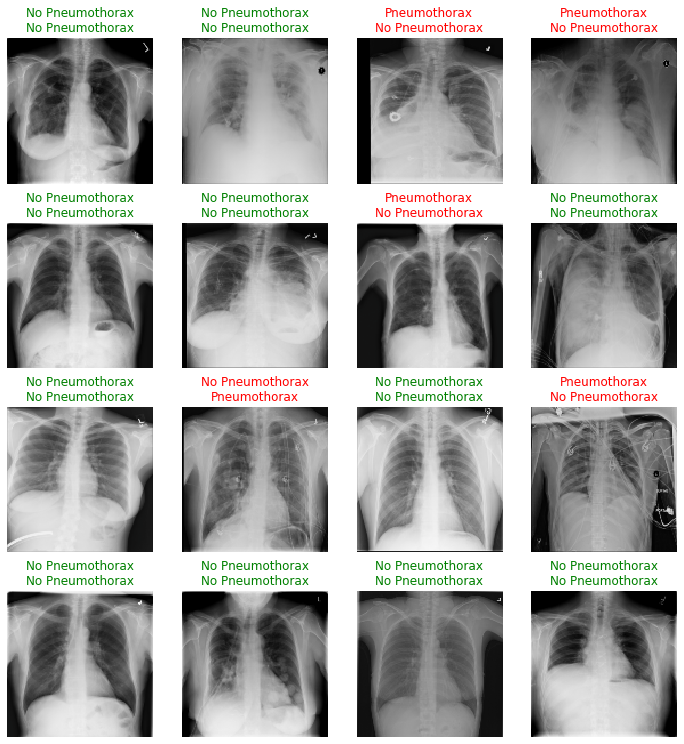

In [ ]:
learn.show_results(max_n=16)

In [ ]:
interp = Interpretation.from_learner(learn)

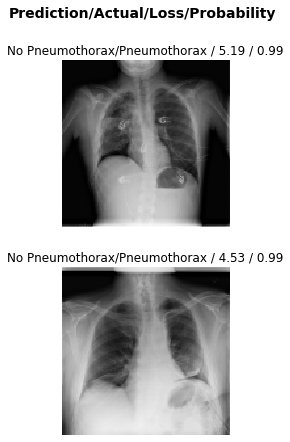

In [ ]:
interp.plot_top_losses(2)

_**Citation:**_

\[1\] _Filice R et al. Crowdsourcing pneumothorax annotations using machine learning annotations on the NIH chest X-ray dataset.  J Digit Imaging (2019). https://doi.org/10.1007/s10278-019-00299-9_